# ANZ virtual internship 
## Building a salary predicting model

Using the same transaction dataset, identify the annual salary for each customer

Explore correlations between annual salary and various customer attributes (e.g. age). These attributes could be those that are readily available in the data (e.g. age) or those that you construct or derive yourself (e.g. those relating to purchasing behaviour). Visualise any interesting correlations using a scatter plot.

Build a simple regression model to predict the annual salary for each customer using the attributes you identified above

How accurate is your model? Should ANZ use it to segment customers (for whom it does not have this data) into income brackets for reporting purposes?

For a challenge: build a decision-tree based model to predict salary. Does it perform better? How would you accurately test the performance of this model?

# Import libraries and data

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline

In [270]:
df = pd.read_excel('clean_anz.xlsx')
df.head(2)

,status,card_present_flag,account,currency,txn_description,merchant_id,first_name,balance,gender,age,...,merchant_long_lat,movement,date,month,weekday,day,time,hour,c_long,c_lat
0,authorized,1.0,ACC-1598451071,AUD,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,F,26,...,153.38 -27.99,debit,2018-08-01,8,2,1,01:01:15,1,153.41,-27.95
1,authorized,0.0,ACC-1598451071,AUD,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,F,26,...,151.21 -33.87,debit,2018-08-01,8,2,1,01:13:45,1,153.41,-27.95


### Annual salary for each customer

In [271]:
# make a new dataframe with only salary payments
df_salaries = df[df['txn_description']=='PAY/SALARY'].groupby('customer_id').sum()

In [272]:
# divide the sum of each customer's salary payment with 3 to get an average monthly pay 
# and then multiply with 12 to get an annual salary
annual_salaries = df_salaries['amount']/3*12 # annual salary for each customer

In [273]:
annual_salaries

customer_id
CUS-1005756958     50464.44
CUS-1117979751    100202.20
CUS-1140341822     45996.24
CUS-1147642491     88992.28
CUS-1196156254    109304.44
                    ...    
CUS-72755508       34815.36
CUS-809013380      53927.64
CUS-860700529      43406.88
CUS-880898248      34415.52
CUS-883482547     111368.88
Name: amount, Length: 99, dtype: float64

In [274]:
annual_salaries.iloc[1]

100202.20000000001

In [275]:
annual_salaries.loc['CUS-1005756958']

50464.44

In [276]:
# match every customer_id with their calculated annual salary
salaries = []

for i in df['customer_id']:
    salaries.append(int(annual_salaries.loc[i]))
    
df['annual_salary'] = salaries

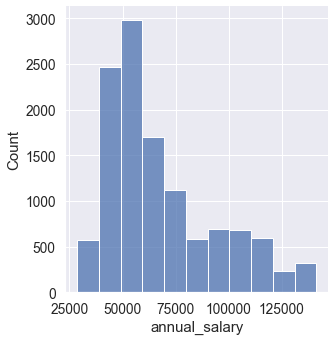

In [277]:
sns.displot(df['annual_salary'], bins=11);

In [278]:
df.head(2)

,status,card_present_flag,account,currency,txn_description,merchant_id,first_name,balance,gender,age,...,movement,date,month,weekday,day,time,hour,c_long,c_lat,annual_salary
0,authorized,1.0,ACC-1598451071,AUD,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,F,26,...,debit,2018-08-01,8,2,1,01:01:15,1,153.41,-27.95,56765
1,authorized,0.0,ACC-1598451071,AUD,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,F,26,...,debit,2018-08-01,8,2,1,01:13:45,1,153.41,-27.95,56765


In [279]:
df.corr()['annual_salary'].sort_values(ascending=False)

annual_salary        1.000000
balance              0.257159
amount               0.091111
age                  0.035041
day                  0.018755
c_lat                0.002112
month               -0.000078
card_present_flag   -0.018942
weekday             -0.046449
hour                -0.046868
c_long              -0.130515
Name: annual_salary, dtype: float64

### create additional features

In [ ]:
# df_cus$age_below20 <- ifelse(df_cus$age<20,1,0)
# df_cus$age_btw20n40 <- ifelse(df_cus$age>=20 & df_cus$age <40,1,0)
# df_cus$age_btw40n60 <- ifelse(df_cus$age>=40 & df_cus$age <60,1,0) 

In [ ]:
# investigate the state where customers live
# assume they live where most transactions occured (indicated by merchant_state)
df_region <-df_csmp %>%
 group_by(customer_id,merchant_state) %>%
 summarize(trans_count=n()) %>%
 group_by(customer_id) %>%
 mutate (no_state = n()) %>%
 filter(trans_count == max(trans_count))
# For equal number of transactions between multiple States, pick the most likely State
n_occur = data.frame(table(df_region$customer_id))
cus_id_rep = n_occur$Var1[n_occur$Freq > 1] 

In [ ]:
"avg_no_weekly_trans","max_amount", "no_large_trans", "use_no_day","avg_trans_amt","med_bal","State") 

### Encoding categorical features

In [280]:
cat_feats = df[['status', 'txn_description', 'gender']]

In [281]:
cat_feats = pd.get_dummies(cat_feats, drop_first=True)
cat_feats.head(2)

,status_posted,txn_description_PAY/SALARY,txn_description_PAYMENT,txn_description_PHONE BANK,txn_description_POS,txn_description_SALES-POS,gender_M
0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0


In [282]:
# ADD NEW FEATURES CREATED
num_feats = df[['balance', 'age', 'amount', 'c_long', 'c_lat']]
num_feats.head(2)

,balance,age,amount,c_long,c_lat
0,35.39,26,16.25,153.41,-27.95
1,21.20,26,14.19,153.41,-27.95


### Scale numerical features

In [283]:
from sklearn.preprocessing import MinMaxScaler

In [284]:
scaler_x = MinMaxScaler()
num_feats_scaled = scaler_x.fit_transform(num_feats)

salary = df['annual_salary'].values.reshape(-1, 1)
scaler_y = MinMaxScaler()
salary_scaled = scaler_y.fit_transform(salary)

In [285]:
# get column names
scaled_num_df = pd.DataFrame(data = num_feats_scaled, columns = num_feats.columns, index = num_feats.index)
# Pass the index of index df_merged_num, otherwise it will sum up the index.

In [286]:
scaled_y = pd.DataFrame(data = salary_scaled, columns = ['annual_salary'], index = num_feats.index)

In [287]:
# merge model features to one dataframe
frames = [scaled_num_df, cat_feats]
model_feats = pd.concat(frames, axis=1)

### Split train and test data

In [316]:
X = model_feats
y = scaled_y

In [317]:
from sklearn.model_selection import train_test_split

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Creating a Model

In [319]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error, r2_score

In [320]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [321]:
lm = LinearRegression()
lm.fit(X_train,y_train)
preds_lm = lm.predict(X_test)

### Valuating the model

In [322]:
from sklearn import metrics
from sklearn.metrics import r2_score, explained_variance_score

In [323]:
print('R-squared', r2_score(y_test, preds_lm)) # accounts for the variation
print('MAE:', metrics.mean_absolute_error(y_test, preds_lm))
print('MSE:', metrics.mean_squared_error(y_test, preds_lm))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, preds_lm))) # directly comparable witht data, $

R-squared 0.13239269032756418
MAE: 0.17134646924834285
MSE: 0.04783664757256209
RMSE: 0.2187159060803811


In [328]:
preds_lm

array([[61776.95656583],
       [68907.63320046],
       [61700.60078632],
       ...,
       [63271.29120198],
       [63423.86857743],
       [61449.06950163]])

In [327]:
y_test

array([[ 43406.],
       [ 69590.],
       [ 52110.],
       ...,
       [ 45996.],
       [102070.],
       [ 52110.]])

In [326]:
preds_lm = scaler_y.inverse_transform(preds_lm)
y_test = scaler_y.inverse_transform(y_test)

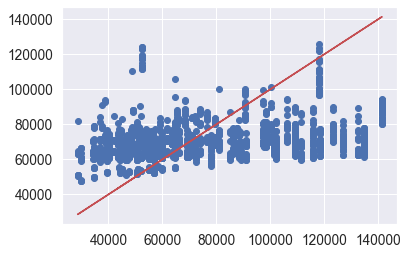

In [330]:
# Our predictions
plt.scatter(y_test, preds_lm)

# Perfect predictions
plt.plot(y_test, y_test,'r')

In [335]:
# Test data real sale price dataframe
test_salary_df = pd.DataFrame(y_test, columns=['Test Y'])

# Predicted prices dataframe
preds_reshape = pd.Series(preds_lm.reshape(3576,))
preds = pd.DataFrame(preds_reshape, columns = ['Predicted'])

# Merge real price and predicted price dataframes
compare_salary_df = pd.merge(test_salary_df, preds, how = 'inner', left_index = True, right_index = True)
compare_salary_df.head(5)

,Test Y,Predicted
0,43406.0,61776.956566
1,69590.0,68907.633200
2,52110.0,61700.600786
3,79524.0,69535.831885
4,59290.0,71168.197645


In [336]:
# Add a new column with error in prediction compared
compare_salary_df['Error'] = compare_salary_df['Test Y'] - compare_salary_df['Predicted']

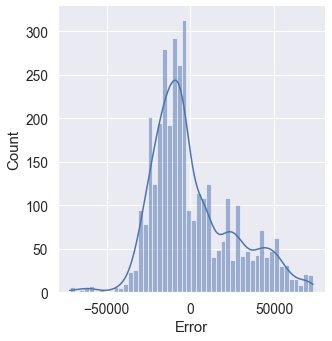

In [337]:
sns.displot(compare_salary_df['Error'], bins = 50, kde = True)